<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [14]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re 

from datetime import datetime, date, time, timezone, timedelta
from functools import reduce 
from collections import defaultdict 

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sales_data_with_stores.csv',
 'scanner_data.csv',
 'mall_customers.csv',
 'sales_vs_discount.csv',
 'groceries.csv',
 'sample-sales-data.csv',
 '1_orders_dataset.csv',
 '1_customers_dataset.csv',
 'match_result_test.csv',
 '1_order_payments_dataset.csv',
 'sales.csv',
 'test.csv',
 'online_retail.xlsx',
 'ecommerce-data.csv',
 'mock_sales_data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'online_retail_II.xlsx',
 'sample_data']

In [3]:
df = pd.read_csv('1_customers_dataset.csv')
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
zip_range = df.groupby(['customer_state'])['customer_zip_code_prefix'].agg(['min', 'max', 'std']).reset_index()
zip_range.head()

,customer_state,min,max,std
0,AC,69900,69980,16.271662
1,AL,57010,57975,264.487732
2,AM,69005,69800,128.339859
3,AP,68900,68997,16.388414
4,BA,40010,48990,2742.967242


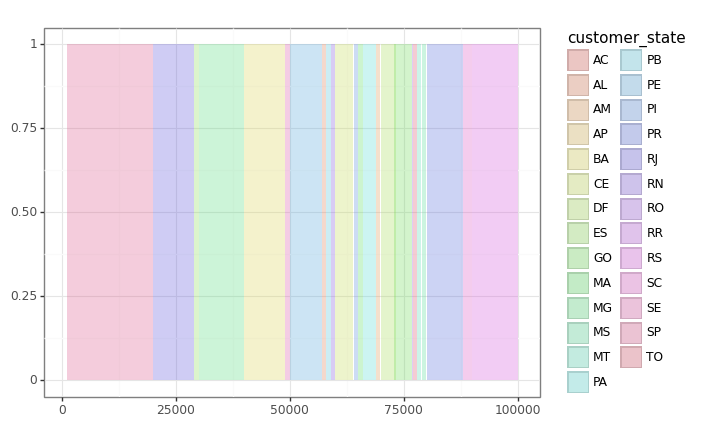

<ggplot: (8791316860837)>

In [8]:
(
    ggplot(zip_range) +
    gg.geom_rect(aes(xmin = 'min', xmax = 'max', ymin = 0, ymax = 1, fill = 'customer_state'), alpha = .3) +
    gg.theme_bw()
)

In [22]:
cnt_au = df.groupby(['customer_state'])['customer_id'].count().reset_index()
cnt_au.columns = ['state', 'au']
cnt_au['ratio'] = round(cnt_au['au']/cnt_au['au'].sum()*100,2)
cnt_au.head()

,state,au,ratio
0,AC,81,0.08
1,AL,413,0.42
2,AM,148,0.15
3,AP,68,0.07
4,BA,3380,3.40


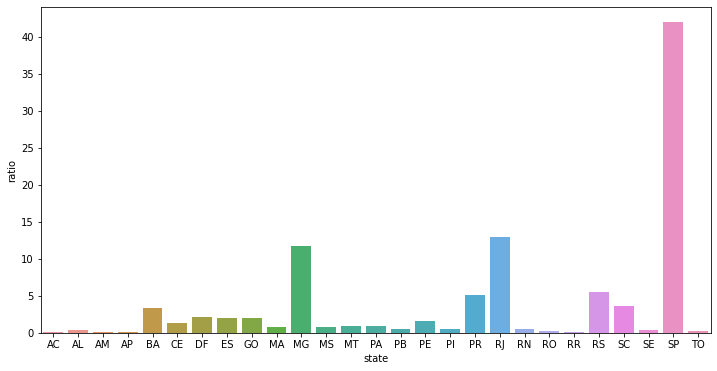

In [23]:
plt.figure(figsize = [12, 6])
sns.barplot(data = cnt_au, x = 'state', y = 'ratio')

In [27]:
cnt_au = df[df['customer_state'] == 'SP'].groupby(['customer_city'])['customer_id'].count().reset_index()
cnt_au.columns = ['city', 'au']
cnt_au['ratio'] = round(cnt_au['au']/cnt_au['au'].sum()*100,2)
cnt_au = cnt_au.sort_values(['ratio'], ascending = False)
cnt_au.head()

,city,au,ratio
551,sao paulo,15540,37.23
104,campinas,1444,3.46
211,guarulhos,1189,2.85
535,sao bernardo do campo,938,2.25
526,santo andre,796,1.91


In [29]:
list_sp = df[df['customer_city'] == 'sao paulo']
list_sp.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
13,eabebad39a88bb6f5b52376faec28612,295c05e81917928d76245e842748184d,5704,sao paulo,SP
18,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP
22,2938121a40a20953c43caa8c98787fcb,482441ea6a06b1f72fe9784756c0ea75,5713,sao paulo,SP


In [30]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sales_data_with_stores.csv',
 'scanner_data.csv',
 'mall_customers.csv',
 'sales_vs_discount.csv',
 'groceries.csv',
 'sample-sales-data.csv',
 '1_orders_dataset.csv',
 '1_customers_dataset.csv',
 'match_result_test.csv',
 '1_order_payments_dataset.csv',
 'sales.csv',
 'test.csv',
 'online_retail.xlsx',
 'ecommerce-data.csv',
 'mock_sales_data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'online_retail_II.xlsx',
 'sample_data']

In [44]:
df_ord = pd.read_csv('1_orders_dataset.csv').reindex(['customer_id','order_id', 'order_status', 'order_purchase_timestamp'], axis = 1)
df_ord.order_purchase_timestamp = pd.to_datetime(df_ord.order_purchase_timestamp, infer_datetime_format=True)
df_ord['date'] = df_ord.order_purchase_timestamp.to_numpy().astype('datetime64[D]')
df_ord['week'] = df_ord['date'] - df_ord['date'].dt.weekday.astype('timedelta64[D]')
df_ord.head()

,customer_id,order_id,order_status,order_purchase_timestamp,date,week
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02,2017-10-02
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-24,2018-07-23
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08,2018-08-06
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18,2017-11-13
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13,2018-02-12


In [45]:
df_pay = pd.read_csv('1_order_payments_dataset.csv').reindex(['order_id', 'payment_type','payment_value'], axis = 1)
df_pay.head()

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,65.71
3,ba78997921bbcdc1373bb41e913ab953,credit_card,107.78
4,42fdf880ba16b47b59251dd489d4441a,credit_card,128.45


In [47]:
df = pd.merge(pd.merge(df_ord, list_sp, 'left','customer_id'), df_pay, 'left', 'order_id').reindex(['customer_id', 'order_status','date','week', 'customer_city', 'payment_type', 'payment_value'], axis = 1)
df.head()

,customer_id,order_status,date,week,customer_city,payment_type,payment_value
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,credit_card,18.12
1,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,voucher,2.00
2,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,voucher,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-23,NaN,boleto,141.46
4,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-06,NaN,credit_card,179.12


In [50]:
df = df[df['customer_id'].isin(list_sp['customer_id'])]
df.head()

,customer_id,order_status,date,week,customer_city,payment_type,payment_value
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,credit_card,18.12
1,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,voucher,2.00
2,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,sao paulo,voucher,18.59
14,7711cf624183d843aafe81855097bc37,delivered,2017-07-13,2017-07-10,sao paulo,credit_card,114.13
16,19402a48fe860416adf93348aba37740,delivered,2018-07-25,2018-07-23,sao paulo,credit_card,32.70


In [60]:
list_pu = dict(zip(df['customer_id'].sort_values().unique(), range(len(df))))
df = df.assign(customer_id = df['customer_id'].apply(lambda x : list_pu.get(x,x)))
df.head()

,customer_id,order_status,date,week,customer_city,payment_type,payment_value
0,9761,delivered,2017-10-02,2017-10-02,sao paulo,credit_card,18.12
1,9761,delivered,2017-10-02,2017-10-02,sao paulo,voucher,2.00
2,9761,delivered,2017-10-02,2017-10-02,sao paulo,voucher,18.59
14,7271,delivered,2017-07-13,2017-07-10,sao paulo,credit_card,114.13
16,1578,delivered,2018-07-25,2018-07-23,sao paulo,credit_card,32.70


In [61]:
df.columns = ['id', 'status', 'date', 'week', 'city', 'type', 'rev']
df.head()

,id,status,date,week,city,type,rev
0,9761,delivered,2017-10-02,2017-10-02,sao paulo,credit_card,18.12
1,9761,delivered,2017-10-02,2017-10-02,sao paulo,voucher,2.00
2,9761,delivered,2017-10-02,2017-10-02,sao paulo,voucher,18.59
14,7271,delivered,2017-07-13,2017-07-10,sao paulo,credit_card,114.13
16,1578,delivered,2018-07-25,2018-07-23,sao paulo,credit_card,32.70


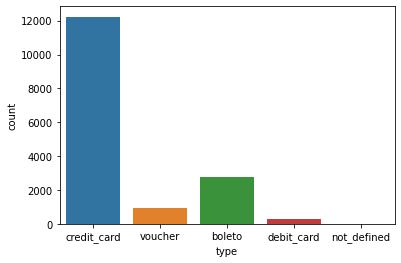

In [64]:
sns.countplot(data = df, x = 'type')

In [68]:
cnt_type = df.groupby(['type','status'])['id'].count().reset_index().rename(columns = {'id':'count'})
cnt_type['ratio'] = cnt_type.groupby(['type'])['count'].apply(lambda x : round(x/x.sum()*100,2))
cnt_type.head()

,type,status,count,ratio
0,boleto,canceled,21,0.75
1,boleto,delivered,2701,97.05
2,boleto,invoiced,5,0.18
3,boleto,processing,8,0.29
4,boleto,shipped,23,0.83


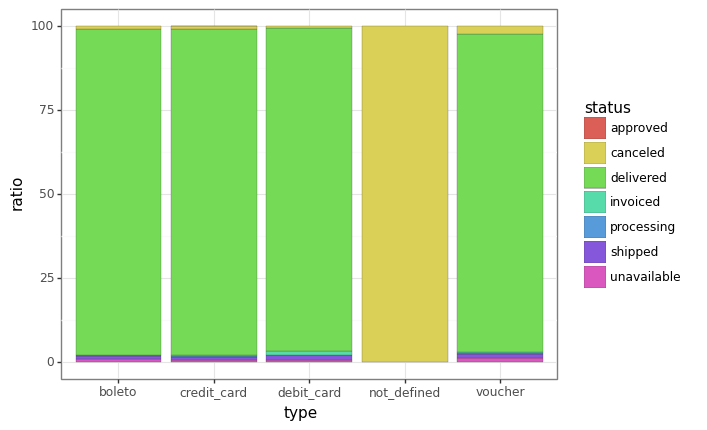

<ggplot: (8791296578045)>

In [71]:
(
    ggplot(cnt_type, aes('type', 'ratio', fill = 'status')) +
    gg.geom_col(color = '#333333', size = 0.1) + 
    gg.theme_bw()
)

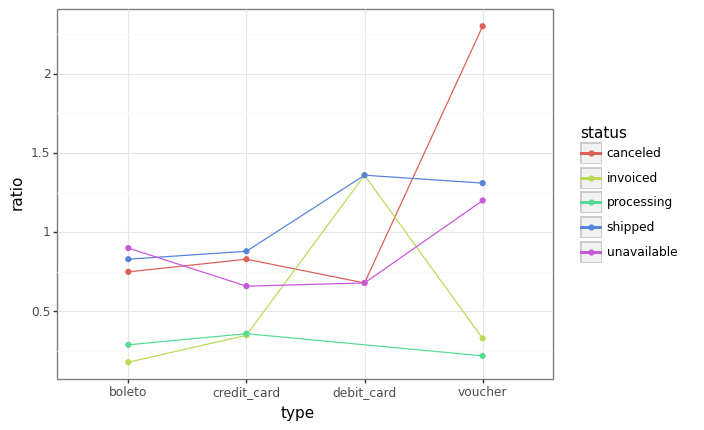

<ggplot: (8791295639293)>

In [79]:
(
    ggplot(cnt_type[~(cnt_type['type'].isin(['not_defined'])) & (~cnt_type['status'].isin(['delivered', 'approved']))], 
           aes('type', 'ratio', color = 'status', group = 'status')) +
    gg.geom_line() + 
    gg.geom_point() +
    gg.theme_bw()
)

# Iterators

In [80]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [82]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [83]:
reduce(lambda x, y : x + y['age'], users, 0)

227

In [84]:
reduce(lambda x, y : x + [y['sex']], users, [])

['M', 'F', 'M', 'F', 'F']